### Let's do a simple analysis of the cleaned dataset.

In [160]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import requests
import urllib.parse

In [161]:
homes = pd.read_csv('clean_data.csv')
homes.drop(homes.columns[[0]], axis=1, inplace=True)
homes.head()

,address,city,community,price,walk_score,listed_by,days_on_site,mls_id,type,style,...,total_parking,est_annual_tax,tax_year,fronting_on,frontage,lot_depth,lot_units,pool,cross_street,district
0,26 Brule Crescent,Toronto,High Park-swansea,2950000,65.0,"Zolo Realty, Brokerage",2,W4763019,detached,1 1/2 storey,...,4.0,11400.88,2019,S,51.73,108.75,Feet,True,Bloor Street/South Kingsway,Toronto W01
1,9 Millgate Crescent,Toronto,Bayview Village,1890000,64.0,"Zolo Realty, Brokerage",9,C4755976,detached,bungalow,...,5.0,8452.60,2019,E,51.42,122.00,Feet,False,Bayview/ Sheppard,Toronto C15
2,49 Morningside Avenue,Toronto,Guildwood,849999,16.0,"Zolo Realty, Brokerage",14,E4753112,detached,bungalow-raised,...,4.0,3196.80,2019,E,43.00,117.00,Feet,False,Guildwood Pkwy/Morningside,Toronto E08
3,47 Morningside Avenue,Toronto,Guildwood,795000,16.0,"Zolo Realty, Brokerage",4,E4725946,detached,bungalow-raised,...,4.0,3146.09,2019,E,43.02,117.00,Feet,False,Guildwood Parkway/Morningside,Toronto E08
4,39 Patricia Avenue,Toronto,Newtonbrook West,1439000,NaN,"Aimhome Realty Inc., Brokerage",1,C4763597,detached,2-storey,...,7.0,4630.76,2019,S,50.00,132.00,Feet,False,Yonge & Finch,Toronto C07


##### I want to start with exploring price. I'll plot a histogram of the dataset

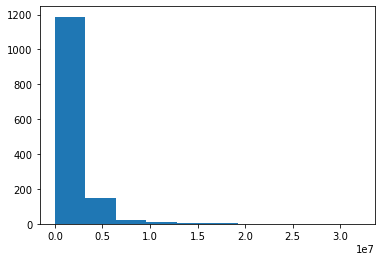

In [196]:
plt.hist(homes.price)
plt.show()

##### It's pretty clear that this dataset is positively skewed and most house prices are right around the one million dollar mark. I won't correct for skewness here since I won't be training the dataset.

##### The next thing I want to do is get a visual on where houses are and how they're priced according to location. To do this, I'll have to build a full address column and call an API to get the exact coordinates.

In [163]:
homes['full_address'] = homes['address'] + ", " + homes["city"] + ", Ontario"
iter_address = homes['full_address'].values
address_url = []
for address in iter_address:
    new_url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'
    address_url.append(new_url)
homes['address_url'] = address_url
coordinates = []
for url in address_url:
    response = requests.get(url).json()
    try:
        lat = response[0]['lat']
        lon = response[0]['lon']
    except IndexError:
        lat = 'nan'
        lon = 'nana'
    nates = lat, lon
    coordinates.append(nates)
lat,lon = map(list,zip(*coordinates))
homes['lon'] = lat
homes['lat'] = lon

In [164]:
homes['lon'] = pd.to_numeric(homes['lon'],errors='coerce')
homes['lat'] = pd.to_numeric(homes['lat'],errors='coerce')

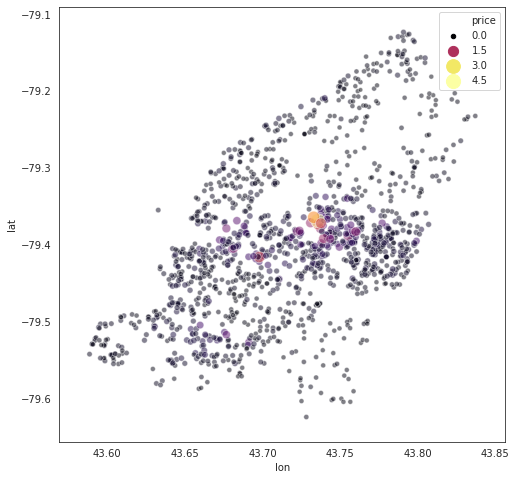

In [307]:
fig = plt.gcf()
fig.set_size_inches(8, 8)
with sns.axes_style("white"):
    g = sns.scatterplot(
        data=homes, x="lon", y="lat", hue="price", size="price",
        sizes=(20, 200), legend='brief', alpha=0.5, palette="inferno"
    )

##### It's clear that there's a relationship between location and price. Most high-priced outliers in this dataset are concentrated in one location...let's look into median home prices by neighbourhood

In [320]:
median_neighbourhood_price = homes.groupby(['community']).median().reset_index() # grouping homes by community

# getting the count of homes in each neighbourhood
count = homes.groupby(['community']).count()
count = count['address'].values
median_neighbourhood_price['num_homes'] = count # adding to dataframe

summary = median_neighbourhood_price.loc[:,['community', 'num_homes','price']] # building summary table
summary.sort_values(by=['price'], ascending=False)

,community,num_homes,price
44,Forest Hill South,12,5497500.0
15,Bridle Path-sunnybrook-york Mills,35,4680000.0
43,Forest Hill North,2,4475000.0
20,Casa Loma,10,3725000.0
4,Banbury-don Mills,32,3534000.0
...,...,...,...
59,Ionview,1,799000.0
92,Oakridge,5,799000.0
12,Black Creek,3,789000.0
54,Humber Summit,3,779000.0


##### We can now see that the plot makes intuitive sense. If you're familiar with the GTA area, you'd notice right away that the areas with the highest priced homes are concentrated in the top 5 communities in this list

##### The next thing I want to look at is if there's any relationship between prices and other quantitative variables

In [197]:
quant_features = homes.select_dtypes(include=[np.number])
quant_features = quant_features.fillna(0)
quan_features = quant_features.drop(['est_annual_tax','lon','lat','tax_year'], axis=1, inplace=True) # dropping irrelevant columns
quant_features.head()
quant_features.fillna(0)
corr = quant_features.corr() # building a correlation matrix
print(corr['price'].sort_values(ascending=False), '\n')

price              1.000000
bathrooms          0.684893
total_parking      0.598560
frontage           0.571427
parking_places     0.556616
covered_parking    0.508710
bedrooms           0.422760
lot_depth          0.416044
days_on_site       0.325883
Bedrooms Plus      0.101229
kitchens           0.035261
walk_score        -0.128722
Name: price, dtype: float64 



##### A very basic conclusion that can be drawn is that there's a strong positive relationship between the home prices in this sample set and the number of bathrooms, parking spaces, and frontage. There's a slightly negative relationship between price and walkscore, which *could* just mean that larger (higher priced) homes in more suburban areas have limited access to transit and storefronts

##### To take this a level deeper, let's plot location and walk score:

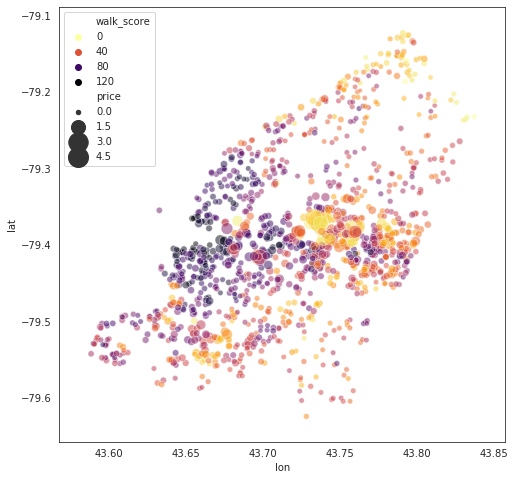

In [308]:
fig = plt.gcf()
fig.set_size_inches(8, 8)
with sns.axes_style("white"):
    g = sns.scatterplot(
        data=homes, x="lon", y="lat", hue="walk_score", size="price",
        sizes=(20, 400), legend="brief", alpha=0.5, palette="inferno_r"
    )

##### This makes the picture a lot more clear. On the west end of this plot is Yorkville, which appropriately has higher walk scores than affluent neighbourhoods in Forest Hill towards the center of the plot. However, it doesn't make intuitive sense that in the lower left quadrant, which is closer to the Downtown Core, that there are such low scores assigned to these homes.

##### To wrap this up, the last question I have is - does a pool strongly influence home price?

In [332]:
grouped = homes.groupby(['pool'], as_index=False).agg(['median', 'count']).loc[:,['pool', 'price']] # aggregate summary statistics
grouped

price      
        median count
pool                
False  1599000  1320
True   2950000    51

##### So, although there is an evident relationship between having a pool and the price of a home, there are still some major considerations here; to what extent does a pool influence the price of a home? It could be that there is a higher concentration of pools in more affluent neighbourhoods. 

##### To take this analysis a step further, it would be ideal to train and score each variable from a larger database of homes in the GTA area.